In [2]:
import numpy as np
#import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Metropolis MCMC for 2D Gaussian Distribution

$$f_{\mathbf x}(\mathbf{x}) =
\frac{1}{\sqrt{(2\pi)^{k}|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})
\right)$$

$$\boldsymbol{\mu} = \begin{bmatrix} 1 \\ 2 \end{bmatrix}, \quad \boldsymbol{\Sigma} = \begin{bmatrix} 25 & 3.5 \\ 3.5 & 1\end{bmatrix}$$

We need to write python functions for:

* the distribution to sample,
* the proposal function
* acceptance functions, and
* the driver routine to glue everything together.

We can also write a function to visualize the samples.

In [3]:
def MultiDNorm(x, m, S):
    """the target distribution, x = [x1, x2],
       m = mean, and S is the covariance matrix"""
    k = len(x)

    m.reshape(k,1)
    x.reshape(k,1)

    v = np.exp(-0.5 * np.dot((x-m).T, np.dot(np.linalg.inv(S), (x-m))))

    return v/np.sqrt((2*np.pi)**k * np.linalg.det(S))

def proposal(oldx, delta):
#    newx = oldx + np.random.uniform(-delta, delta, oldx.shape)
    newx = oldx + np.random.normal(loc=0., scale=delta, size=oldx.shape)
    return newx

def metropolis_accept(newx, oldFuncVal, m, S, func):

    accept     = False
    newFuncVal = func(newx, m, S)
    ratio      = newFuncVal/(oldFuncVal + 1.0e-21)

    if ratio > 1.:
        accept = True
    elif np.random.rand() < ratio:
        accept = True

    return accept, newFuncVal

def driver(delta, nsteps=10000, thin=10):

    mu = np.array([1., 2.]).reshape(2,1)
    Sig = np.array([[25., 3.5], [3.5, 1.]])

#   Toggle these to play with initial condition
#    np.random.seed(12345)
#    x = mu.copy()
    x        = np.array([-15., 7.]).reshape(2,1)
#    x = np.array([np.random.uniform(-15, 15), np.random.uniform(-2, 7)]).reshape(2,1)

    f        = MultiDNorm(x, mu, Sig)
    AccRatio = 0.0
    NumSucc  = 0
    recz     = np.zeros((int(nsteps/thin), 2))

    for iMCS in range(nsteps):

        newx = proposal(x, delta)
        accept, newf = metropolis_accept(newx, f, mu, Sig, MultiDNorm)

        if accept:
            NumSucc += 1
            x = newx
            f = newf

        if (iMCS % thin) == 0:
            recz[int(iMCS/thin)] = x.T

    AccRatio = float(NumSucc)/float(nsteps)

    return recz, AccRatio

def plotChainDist(delta, nsteps=10000):

    from scipy.stats import multivariate_normal

    recz, ar = driver(delta, nsteps)
    plt.plot(recz[:,0],recz[:,1],'k.-', alpha=0.3)


    X, Y = np.mgrid[-20:20:.1, -5:10:.1]
    Z = np.dstack((X, Y))
    rv = multivariate_normal([1., 2.], [[25., 3.5], [3.5, 1.]])
    plt.contourf(X, Y, rv.pdf(Z), cmap=cm.OrRd)

    plt.title('$\delta$ = {0:0.2f}'.format(delta))

    Nburn = 100
    meanx, meany = np.mean(recz[Nburn:-1,0]), np.mean(recz[Nburn:-1,1])
    a = recz[Nburn:-1,0]**2 + recz[Nburn:-1,1]**2
    print("axRatio\t{0:0.4f}\nMean(x)\t{1:0.4f}\nMean(y)\t{2:0.4f}\nMean(a)\t{3:0.4f}".format(ar, meanx, meany, np.mean(a)))

axRatio	0.7660
Mean(x)	2.9844
Mean(y)	2.3296
Mean(a)	41.2478


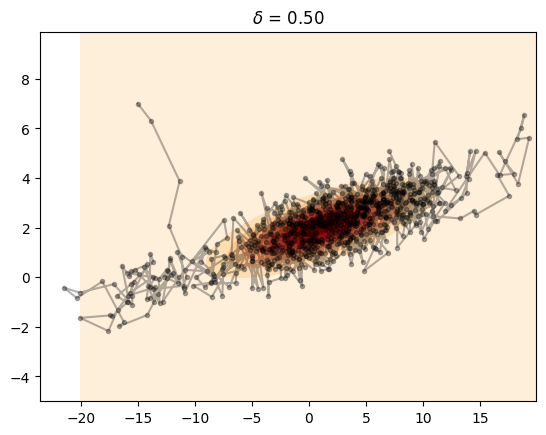

In [4]:
# try delta = 0.3, 0.5, 1.0, 2.0
delta = 0.5
plotChainDist(delta, 10000)

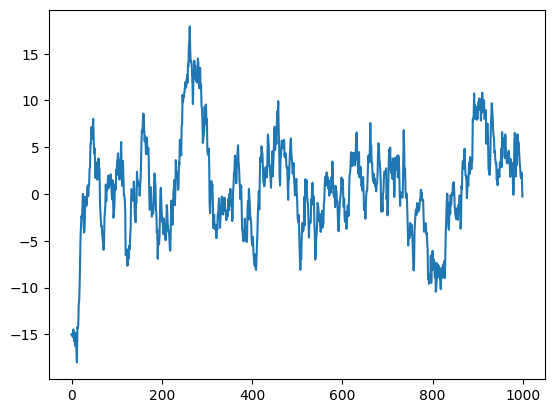

In [5]:
recz, ar = driver(delta, 10000);
plt.plot(recz[:,0])

# Utility Functions

* Gelman Rubin Diagnostic
* Autocorrelation Function
* Block Averaging

In [6]:
def GelmanRubin(A, M, n):
    """A is a matrix with n columns and M rows
    Aij = ith sample from jth chain"""

    sj2 = np.zeros(n); aj  = np.zeros(n)

    for j in range(n):
        sj2[j] = np.var(A[:,j])
        aj[j]  = np.mean(A[:,j])

    W  = np.mean(sj2) # within-chain
    B  = M * np.var(aj)
    s2 = (1. - 1./M)*W + 1./M * B # inter-chain
    R  = np.sqrt(s2/W)

    return R, s2, W, B

def autocorr(x, NA = 0):
    """Given vector x, computes  <x(t) x(0)>/<x(0) x(0)>
    If NA specified, NA elements of ACF are computed
    Otherwise, NA = N - 1 by default."""

    x = x - np.mean(x) # subtract mean from "x"
    N = len(x)         # size of "x"

    # If NA is not specified

    if(NA == 0):
    	    NA = N - 1

def blockAverage(datastream, isplot=True, maxBlockSize=0):

    """use block average of correlated timeseries x,
       to provide error bounds for the estimated mean <x>.
       If maxBlockSize = 0, it is set to Nobs/4."""

    Nobs         = len(datastream)  # # observations
    minBlockSize = 1;               # min: 1 obsv/block

    if maxBlockSize == 0:
        maxBlockSize = int(Nobs/4); # max: 4 blocs

    # total number of block-sizes
    NumBlocks = maxBlockSize - minBlockSize

    # mean and variance for each block size
    blockMean = np.zeros(NumBlocks)
    blockVar  = np.zeros(NumBlocks)
    blockCtr  = 0

    #  blockSize is # observations/block
    #  run them through all possibilities

    for blockSize in range(minBlockSize, maxBlockSize):

        # total number of such blocks in datastream
        Nblock    = int(Nobs/blockSize)
        # container for parcelling block
        obsProp   = np.zeros(Nblock)

        # Loop to chop datastream into blocks
        for i in range(1,Nblock+1):
            ibeg = (i-1) * blockSize
            iend =  ibeg + blockSize
            obsProp[i-1] = np.mean(datastream[ibeg:iend])

        blockMean[blockCtr] = np.mean(obsProp)
        blockVar[blockCtr]  = np.var(obsProp)/(Nblock - 1)
        blockCtr += 1

    v = np.arange(minBlockSize,maxBlockSize)

    if isplot:
        plt.subplot(2,1,1)
        plt.plot(v, np.sqrt(blockVar),'ro-',lw=2)
        plt.xlabel('block size')
        plt.ylabel('std')

        plt.subplot(2,1,2)
        plt.errorbar(v, blockMean, np.sqrt(blockVar))
        plt.ylabel('<x>')
        plt.xlabel('block size')
        plt.show()

    print("<x> = {0:f} +/- {1:f}\n".format(
           blockMean[-1], np.sqrt(blockVar[-1])))

    return v, blockVar, blockMean

# Gelman Rubin Test

Convergence of $A = x^2 + y^2$.

(1.0258768842659112, 589.41794317209, 560.057818400194, 2028.0640569949912)


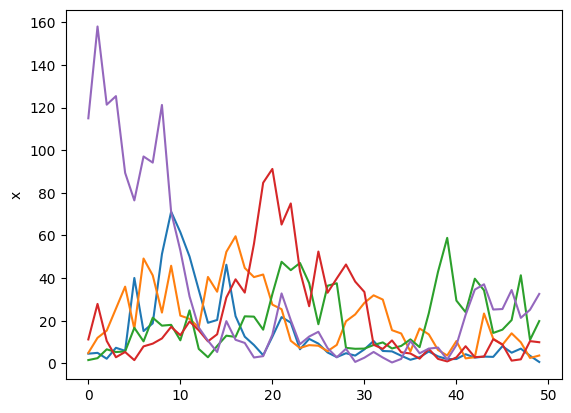

In [7]:
n     = 5
thin  = 10
M     = 50
thin  = 10
delta = 0.5

X = np.zeros((M, n))

for j in range(n):
    c, ar = driver(delta, 2*M*thin, thin)
    X[:,j] = c[M:2*M, 0]**2 + c[M:2*M, 1]**2    # after burnin

    plt.plot(X[:,j])

plt.ylabel('x')

print(GelmanRubin(X, M, n))